This tutorial demonstrates how to get started with JAX transformations in cryoJAX.

In [1]:
# Plotting imports and function definitions
import math

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image_stack(images, cmap="gray", **kwargs):
    n_images_per_side = int(math.sqrt(images.shape[0]))
    fig, axes = plt.subplots(nrows=n_images_per_side, ncols=n_images_per_side)
    vmin, vmax = images.min(), images.max()
    for idx, ax in enumerate(axes.ravel()):
        im = ax.imshow(
            images[idx], cmap=cmap, vmin=vmin, vmax=vmax, origin="lower", **kwargs
        )
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax)
    fig.tight_layout()

In [2]:
# Start by creating an image model
import cryojax.simulator as cxs
from cryojax.io import read_array_from_mrc


# Scattering potential stored in MRC format
filename = "./data/groel_5w0s_scattering_potential.mrc"
# ... read into a FourierVoxelGridPotential
real_voxel_grid, voxel_size = read_array_from_mrc(filename, loads_spacing=True)
potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
    real_voxel_grid, voxel_size, pad_scale=2
)
# Now, instantiate the pose. Angles are given in degrees
pose = cxs.EulerAnglePose(
    offset_x_in_angstroms=5.0,
    offset_y_in_angstroms=-3.0,
    phi_angle=20.0,
    theta_angle=80.0,
    psi_angle=-5.0,
)
# First, the contrast transfer theory
ctf = cxs.AberratedAstigmaticCTF(
    defocus_in_angstroms=10000.0,
    astigmatism_in_angstroms=-100.0,
    astigmatism_angle=10.0,
)
transfer_theory = cxs.ContrastTransferTheory(ctf, amplitude_contrast_ratio=0.1)
# Then the configuration. Add padding with respect to the final image shape.
pad_options = dict(shape=potential.shape[0:2])
config = cxs.BasicConfig(
    shape=(80, 80),
    pixel_size=potential.voxel_size,
    voltage_in_kilovolts=300.0,
    pad_options=pad_options,
)
# Make the image model. By default, cryoJAX will simulate
# the contrast in physical units. Rather, normalize the image.
image_model = cxs.make_image_model(
    potential,
    config,
    pose,
    transfer_theory,
    normalizes_signal=True,
)

In this tutorial, we will show how to perform [transformations](https://docs.jax.dev/en/latest/key-concepts.html#transformations) using `jax.jit`, `jax.grad`, and `jax.vmap`. To do this, we will leverage [filtered transformations](https://docs.kidger.site/equinox/all-of-equinox/#2-filtering) in `equinox`. Start by defining a function that simulates images.

In [3]:
import equinox as eqx


@eqx.filter_jit
def simulate_fn(image_model):
    return image_model.simulate()

!!! info "What's with the eqx.filter_jit?"

    This is an example of a JAX transformation for JIT compilation (i.e. `jax.jit`). If you aren't familar with `jax.jit`, then start by reading the [JAX documentation](https://docs.jax.dev/en/latest/jit-compilation.html#just-in-time-compilation).

    In particular, `eqx.filter_jit` a *filtered transformation* through the package `equinox`. In summary, this is a lightweight wrapper around `jax.jit` that treats all of the `image_model`'s JAX arrays as traced at compile time, and all of its non-JAX arrays as static. If you aren't familiar with static arguments in JAX, see [here](https://docs.jax.dev/en/latest/jit-compilation.html#marking-arguments-as-static).

    Filtered transformations are a key feature of `equinox` and it is highly recommended to learn about them. See [here](https://docs.kidger.site/equinox/all-of-equinox/#2-filtering) in the equinox documentation for an introduction. Note that these transformations are completely optional; the `jax.jit` decorator can also be used if you are willing to write a few more lines of code.

In [4]:
# Compare speed with and without JIT
print("Simulate an image without JIT")
%timeit image_model.simulate().block_until_ready()
print("Simulate an image with JIT")
%timeit simulate_fn(image_model).block_until_ready()

Simulate an image without JIT
27.5 ms ± 618 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Simulate an image with JIT
1.15 ms ± 187 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Indeed there is a large speedup!

Next, let's compute our first gradient. If you haven't yet read about [filtered transformations](https://docs.kidger.site/equinox/all-of-equinox/#2-filtering) in `equinox`, stop and do this now. In particular, read about `equinox.partition` and `equinox.combine`.

Indeed, we could similarly define a function that computes a gradient as 

```python
import equinox as eqx

@eqx.filter_grad
def simulate_fn(image_model):
    return image_model.simulate()
```

The issue is we typically want to take the derivative of only particular parameters, whereas this function would compute the gradient with respect to all JAX arrays in the `image_model`. To solve this, we need more advanced features in `equinox`.

Here we will demonstrating taking the gradient with respect to the pose with a simple L2 loss.

In [5]:
import equinox as eqx
import jax.numpy as jnp

from cryojax.jax_util import get_filter_spec


observed_image = simulate_fn(image_model)

# Split the image model into gradient and non-gradient parameters using
# `eqx.partition` and the cryoJAX `get_filter_spec` utility
where_pose = lambda model: model.structure.pose
filter_spec = get_filter_spec(image_model, where_pose)
model_grad, model_nograd = eqx.partition(image_model, filter_spec)


# Define the gradient function whose first argument is the gradient parameters.
# Use `eqx.combine`` after crossing the gradient boundary
@eqx.filter_jit
@eqx.filter_grad
def gradient_fn(model_grad, model_nograd, observed_image):
    image_model = eqx.combine(model_grad, model_nograd)
    return jnp.sum((simulate_fn(image_model) - observed_image) ** 2)


# Compute and extract the gradients. We took the gradient with respect to
# a cryoJAX `EulerAnglePose` object
gradients = gradient_fn(model_grad, model_nograd, observed_image)
eqx.tree_pprint(where_pose(gradients), short_arrays=False)

EulerAnglePose(
  offset_x_in_angstroms=Array(2.5274601e-05, dtype=float32),
  offset_y_in_angstroms=Array(5.263155e-05, dtype=float32),
  offset_z_in_angstroms=None,
  phi_angle=Array(3.1357773e-05, dtype=float32),
  theta_angle=Array(-1.2311443e-05, dtype=float32),
  psi_angle=Array(6.1060186e-05, dtype=float32)
)


!!! info "What do `eqx.partition` and `eqx.combine` do?"
    
    JAX transformations typically require grouping pytree leaves into different categories. `jax.jit` makes the distinction between traced and static arguments, `jax.vmap` has broadcasted and non-broadcasted arguments, and of course `jax.grad` has differentiated and non-differentiated. `equinox` makes grouping leaves more elegant with the concept of filtering. In this example, we use a `cryojax` utility to create what is called a `filter_spec`, which is a pytree of booleans of the same structure as `image_model`. The values are `True` at leaves specified by `where_pose` and `False` otherwise. Then, `eqx.partition` is used to split up the pytree into differentiated and non-differentiated arguments. Finally, after crossing the `jax.grad` boundary, `eqx.combine` is called to recombine subtrees into a functional `image_model`. It is recommended to learn more about filtering; a good example can be found [here](https://docs.kidger.site/equinox/examples/frozen_layer/).

With this basic recipe, we can also compute batches of images with `jax.vmap`. We will do this here by simulating images with different random poses.

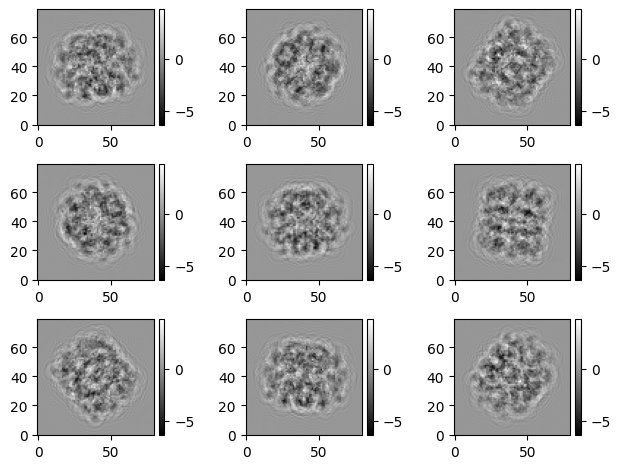

In [6]:
import jax.random as jr

from cryojax.rotations import SO3


# Define function that generates a partitioned `image_model`
@eqx.filter_jit
@eqx.filter_vmap(
    in_axes=(eqx.if_array(0), None, None, None), out_axes=(eqx.if_array(0), None)
)
def make_batched_model(rng_key, potential, config, transfer_theory):
    rotation = SO3.sample_uniform(rng_key)
    pose = cxs.EulerAnglePose.from_rotation(rotation)
    image_model = cxs.make_image_model(
        potential, config, pose, transfer_theory, normalizes_signal=True
    )
    where_pose = lambda model: model.structure.pose
    filter_spec = get_filter_spec(image_model, where_pose)
    model_vmap, model_novmap = eqx.partition(image_model, filter_spec)

    return model_vmap, model_novmap


# Define function that simulates an image from a partitioned `image_model`
@eqx.filter_jit
@eqx.filter_vmap(in_axes=(eqx.if_array(0), None))
def simulate_batch_fn(model_vmap, model_novmap):
    image_model = eqx.combine(model_vmap, model_novmap)
    return image_model.simulate()


# Generate `image_model` for different RNG keys and simulate a batch of images
n_poses = 9
rng_keys = jr.split(jr.key(seed=0), n_poses)
model_vmap, model_novmap = make_batched_model(
    rng_keys, potential, config, transfer_theory
)
images = simulate_batch_fn(model_vmap, model_novmap)
plot_image_stack(images)

Here, we use a `eqx.filter_vmap` for model instantiation and image simulation.

!!! info "Why do we set `out_axes=(0, None)`?"
    
    When we create a pytree with `eqx.filter_vmap` (or `jax.vmap`), `out_axes` should be a prefix output pytree. If `out_axes` is set to `None` at a particular leaf, this
    says that we do not want to broadcast that leaf (of course, this only works for unmapped leaves). By default `jax.vmap` sets `out_axes=0`, so all unmapped leaves get broadcasted. Typically, we only want to broadcast leaves in `cryojax` functions that are directly mapped, so we must set the `out_axes` value at those leaves to `None`.